In [3]:
import os
import matplotlib.pyplot as plt
import torch
import h5py
import random

In [2]:
!pwd

/orfeo/cephfs/home/dssc/ipasia00/federatedlearning/notebooks


In [4]:
# TODO: 
# Edit it accordingly to your needs 

WORK_DIR = '../'
DOWNLOAD_URL = 'https://figshare.com/ndownloader/articles/1512427/versions/5'
DATA_DIR = '../data/'
ZIP_FILE = DATA_DIR + 'BrainCancer.zip'
EXTRACT_DIR = DATA_DIR + 'BrainCancerRawData/'
DOTMAT_DIR = DATA_DIR + 'BrainCancerDotMat/'
DATASET_FILE = DATA_DIR + 'BrainCancerDataset.pt'

In [11]:
# check if the data is already downloaded, if not download it
if not os.path.exists(DATA_DIR):
    os.makedirs(DATA_DIR)
if not os.path.exists(ZIP_FILE):
    os.system('wget -O %s %s' % (ZIP_FILE, DOWNLOAD_URL))
else:
    print('Data already downloaded...\nSkipping download')

Data already downloaded...
Skipping download


In [13]:
# check if the data is already extracted, if not extract it
if not os.path.exists(EXTRACT_DIR):
    print(ZIP_FILE)
    os.system('unzip %s -d %s' % (ZIP_FILE, EXTRACT_DIR))
    # The dataset was split in more .zips files due to the dimension
    to_unzip = []
    # search for all the .zip files in DATA_DIR
    for root, dirs, files in os.walk(EXTRACT_DIR):
        for file in files:
            if file.endswith('.zip'):
                to_unzip.append(os.path.join(EXTRACT_DIR, file))
    print(f"The data were split in {len(to_unzip)} .zip files\n Starting to unzip...")
    # extract it in the DOTMAT_DIR
    os.makedirs(DOTMAT_DIR, exist_ok=True)
    for zip_file in to_unzip:
        print(f"Extracting {zip_file} ...")
        os.system(f'unzip -q {zip_file} -d {DOTMAT_DIR}')
else:
    print('Data already extracted...\nSkipping extraction')
    
print("In total we have ", len(os.listdir(DOTMAT_DIR)), " .mat files!\nStarting to read it ...")

../data/BrainCancer.zip
The data were split in 0 .zip files
 Starting to unzip...
In total we have  0  .mat files!
Starting to read it ...


sh: 1: unzip: not found


In [14]:
# read the .mat files
matfile_names = []
images= []
labels = []

for root, dirs, files in os.walk(DOTMAT_DIR):
    for file in files:
        if file.endswith('.mat'):
            matfile_names.append(os.path.join(DOTMAT_DIR, file))

for matfile in matfile_names:
    with h5py.File(matfile, 'r') as f:
        image = torch.tensor(f['cjdata/image'][:])
        label = torch.tensor(f['cjdata/label'][:]).squeeze()
        # The labels in the dataset are 1-indexed, so we need to subtract 1
        label -= 1
        images.append(image)
        labels.append(label)
print("done!")

done!


In [19]:
# Downloaded Modules
import os
import torch as th
from torch.utils.data import Dataset, DataLoader, Subset, random_split

# Defined Modules
from settings import *


class Dataset(Dataset):
    def __init__ (self, images=None, labels=None, files=None):
        if files is not None:
            self.images = th.FloatTensor()
            self.labels = th.LongTensor()
            self.importFromFiles(files)
        elif images is not None and labels is not None:
            self.images = images.float()
            self.labels = labels.long()
        else:
            raise ValueError("Either images and labels or a list of files should be provided")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]

    def labelStr(self,label):
            return "Meningioma" if label == 0 else "Glioma" if label == 1 else "Pituitary tumor" if label == 2 else "unknown"

    def shuffle(self):
        idx = th.randperm(self.__len__())
        self.images = self.images[idx]
        self.labels = self.labels[idx]

    def train_val_test_split(self, train_percentage=TRAINSIZE, val_percentage=VALSIZE, test_percentage=TESTSIZE):
        if abs(train_percentage + val_percentage + test_percentage -1) > 10E-6:
            train_percentage = 0.7
            val_percentage = 0.15
            test_percentage = 0.15
            print(f"Error with train-val-test percentages, using default values: {train_percentage} {val_percentage} {test_percentage}")
        self.shuffle()
        train_size = int(train_percentage * len(self))
        val_size = int(val_percentage * len(self))
        test_size = len(self) - train_size - val_size
        return random_split(self, [train_size, val_size, test_size])

    def separateClasses(self):
        nClasses = th.max(self.labels)+1
        return [Subset(self, th.where(self.labels == i)[0]) for i in range(nClasses)]

    def splitClasses(self, percentPerClass, save=False):
        """Split the dataset into multiple datasets, one for each class and center, and saves them if desired

        Args:
            percentPerClass (List[List[float]]): List of lists of floats representing the percentage of each class to be in each subset
            save (bool, optional): Decide if to save the created datasets or not. Defaults to False.

        Raises:
            ValueError: raised if the number of percentages arrays is different from the number of classes
            ValueError: raised if the sum of the percentages is not 1 for each class

        Returns:
            List[List[Dataset]]: List of the created datasets, one for each class and center
        """
        datasets = self.separateClasses()
        nClasses = len(datasets)
        if len(percentPerClass) != nClasses:
            raise ValueError(f"The number of percentages arrays should be equal to the number of classes ({nClasses})")
        for percentList in percentPerClass:
            if not th.isclose(th.sum(percentList), 1.0, atol=1e-6):
                raise ValueError(f"The sum of the percentages of each class should be 1, but got {sum(percentList)} in {percentList}")
        output = th.empty((nClasses, len(percentPerClass[0])), dtype=object)
        for i in range(nClasses):
            dataset_size = len(datasets[i])
            split_sizes = [int(p * dataset_size) for p in percentPerClass[i][:-1]]
            split_sizes.append(dataset_size - sum(split_sizes))  # Add the remaining elements to the last subset
            data = random_split(datasets[i], split_sizes)
            for j, subset in enumerate(data):
                # Extract data from the subset
                images = th.stack([subset.dataset[idx][0] for idx in subset.indices])
                labels = th.tensor([subset.dataset[idx][1] for idx in subset.indices])
                # Create a new dataset
                newData = Dataset(images, labels)
                output[i,j] = newData
                if save:
                    label = self.labelStr(i)
                    os.makedirs(f"data/{label}", exist_ok=True)
                    # Save the new dataset
                    th.save(newData, f"data/{label}/{label}{int(percentPerClass[i][j]*100)}_{j}.pt")
        return output.T

    def importFromFiles(self, files):
        """ Import data from the given files (one for each class)

        Args:
            files (List[various]): List of files to import data from (either strings or Dataset objects)

        Raises:
            ValueError: raised if the file does not exist, or if the file does not contain a Dataset object
        """
        imgs = []
        labs = []
        for file in files:
            if isinstance(file, str):
                if not os.path.isfile(file):
                    raise ValueError(f"File {file} does not exist")
                data = th.load(file)
                if not isinstance(data, Dataset):
                    raise ValueError(f"File {file} does not contain a Dataset object")
            elif isinstance(file, Dataset):
                data = file
            else:
                raise ValueError(f"Invalid file type: {type(file)}")
            imgs.append(data.images)
            labs.append(data.labels)
        self.images = th.cat(imgs)
        self.labels = th.cat(labs)
        self.shuffle()


In [20]:
count_512 = 0
count_256 = 0
for i in range(len(images)):
    if images[i][0].shape[0] == 512:
        count_512 += 1
    elif images[i][0].shape[0] == 256:
        count_256 += 1
    else:
        print("Index: ", i, " Shape: ", images[i][0].shape)
print("Images with shape 512x512: ", count_512)
print("Images with shape 256x256: ", count_256)
print("Total images: ", len(images))
print("Dropping the images with shape 256x256 ...")

# there are 12 images (over 3k +) with shape 256x256...
# Just drop it 
index_to_drop = [i for i in range(len(images)) if images[i].shape[0] == 256]

images = [images[i] for i in range(len(images)) if i not in index_to_drop]
labels = [labels[i] for i in range(len(labels)) if i not in index_to_drop]



Images with shape 512x512:  3049
Images with shape 256x256:  15
Total images:  3064
Dropping the images with shape 256x256 ...


In [21]:
# cast to tensor
images_th = torch.stack(images).unsqueeze(1)
labels_th = torch.stack(labels)

print("Generating the dataset ...")
# create the dataset
dataset = Dataset(images_th, labels_th)

Generating the dataset ...


In [22]:
# save the dataset
torch.save(dataset, DATASET_FILE)

Visualize some data: 

In [23]:
# visualize some data
n = 5
rnd_idx = random.sample(range(len(dataset)), n)

def translate_label(label):
    if label == 0:
        return "Meningioma"
    elif label == 1:
        return "Glioma"
    elif label == 2:
        return "Pituitary tumor"
    else:
        return "unknown"

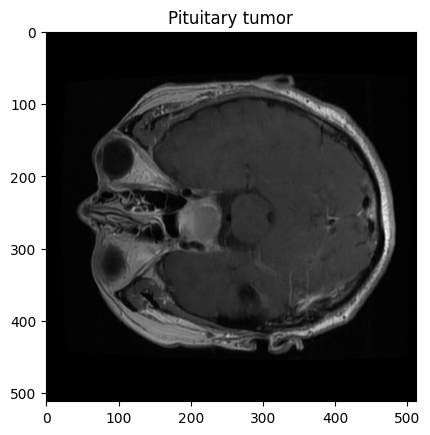

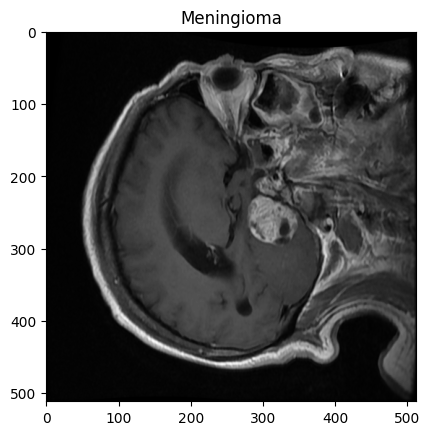

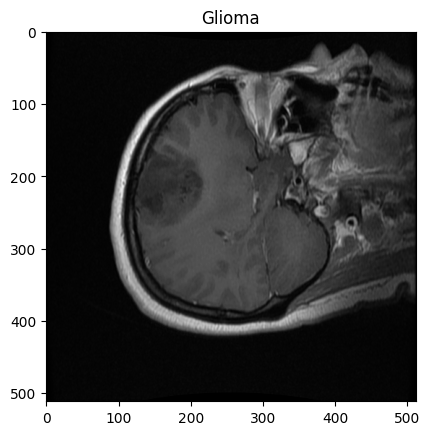

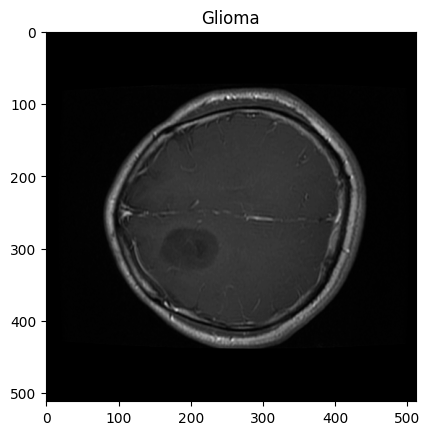

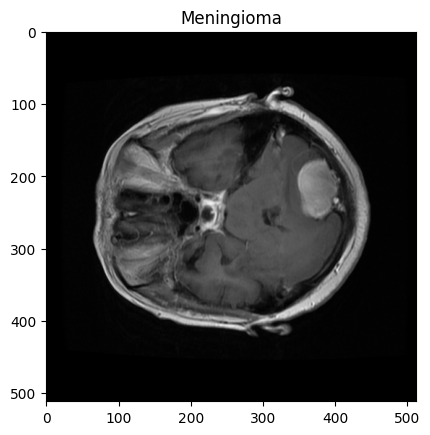

In [24]:
dataset
for i in rnd_idx:
    img = dataset.images[i][0]
    plt.imshow(img, cmap='gray')
    plt.title(f"{translate_label(dataset.labels[i])}")
    plt.show()